In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


In [2]:
import os
import math
import warnings
warnings.filterwarnings('ignore')

from IPython.core.pylabtools import figsize
from IPython.display import Image, HTML
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pymc3 as pm

plt.style.use('ggplot')


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
season_df = pd.read_csv("1920PremierLeague.csv")
season_df = season_df.set_index("Home \ Away")
season_df.index = season_df.columns

In [4]:
season_df.head()

,ARS,AVL,BOU,BHA,BUR,CHE,CRY,EVE,LEI,LIV,MCI,MUN,NEW,NOR,SHU,SOU,TOT,WAT,WHU,WOL
ARS,—,3–2,1–0,1–2,2–1,1–2,2–2,3–2,NaN,NaN,0–3,2–0,4–0,NaN,1–1,2–2,2–2,NaN,1–0,1–1
AVL,NaN,—,1–2,2–1,2–2,NaN,NaN,2–0,1–4,1–2,1–6,NaN,2–0,1–0,NaN,1–3,2–3,2–1,0–0,NaN
BOU,1–1,2–1,—,3–1,0–1,2–2,NaN,3–1,NaN,0–3,1–3,1–0,NaN,0–0,1–1,NaN,NaN,0–3,2–2,1–2
BHA,NaN,1–1,2–0,—,1–1,1–1,0–1,3–2,0–2,NaN,NaN,NaN,NaN,2–0,0–1,0–2,3–0,1–1,1–1,2–2
BUR,0–0,1–2,3–0,NaN,—,2–4,0–2,1–0,2–1,0–3,1–4,0–2,1–0,2–0,NaN,3–0,1–1,NaN,3–0,NaN


In [5]:
#create dataframe where each row corresponds to one game
season_df.index = season_df.columns
rows = []
for i in season_df.index:
    for c in season_df.columns:
        if i == c: continue
        score = season_df[c][i]
        if str(score) in ['nan', 'a']: continue
        score = [int(row) for row in str(score).split('–')]
        rows.append([i, c, score[0], score[1]])
df = pd.DataFrame(rows, columns = ['home', 'away', 'home_score', 'away_score'])
df.head()


,home,away,home_score,away_score
0,ARS,AVL,3,2
1,ARS,BOU,1,0
2,ARS,BHA,1,2
3,ARS,BUR,2,1
4,ARS,CHE,1,2


In [6]:
teams = season_df.columns
teams = pd.DataFrame(teams, columns=['team'])
teams['i'] = teams.index
teams.head()


,team,i
0,ARS,0
1,AVL,1
2,BOU,2
3,BHA,3
4,BUR,4


In [7]:
df = pd.merge(df, teams, left_on='home', right_on='team', how='left')
df = df.rename(columns = {'i': 'i_home'}).drop('team', 1)
df = pd.merge(df, teams, left_on='away', right_on='team', how='left')
df = df.rename(columns = {'i': 'i_away'}).drop('team', 1)
df.head()


,home,away,home_score,away_score,i_home,i_away
0,ARS,AVL,3,2,0,1
1,ARS,BOU,1,0,0,2
2,ARS,BHA,1,2,0,3
3,ARS,BUR,2,1,0,4
4,ARS,CHE,1,2,0,5


In [8]:
observed_home_goals = df.home_score.values
observed_away_goals = df.away_score.values
home_team = df.i_home.values
away_team = df.i_away.values
num_teams = len(df.i_home.unique())


In [9]:
g = df.groupby('i_away')
att_starting_points = np.log(g.away_score.mean())
g = df.groupby('i_home')
def_starting_points = -np.log(g.away_score.mean())


\begin{align}
y_{gj}|\theta_{gj} = Poisson(\theta_{gj}) \\
log(\theta_{g1})= intercept + home_{h(g)} + home_{h(a)} + att_{h(g)} + def_{a(g)} \\
log(\theta_{g2})= intercept - home_{h(a)} - home_{h(g)} + att_{a(g)} + def_{h(g)} \\
\end{align}
\begin{align}
att_{t} & = Normal(0,\tau_{att}) \\
def_{t} & = Normal(0,\tau_{def}) \\
home_{t} & = Normal(0,\tau_{home}) \\
\tau_{att,def,home} & = Gamma(.1,.1)
\end{align}


### Model description
[Based off of the blog post here](http://danielweitzenfeld.github.io/passtheroc/blog/2014/10/28/bayes-premier-league/)

In each game (<sub>g</sub>) we are tring to predict the number of goals for the home team (y<sub>g1</sub>) and away team (y<sub>g2</sub>) which we sample from a poisson distribution based on the underlying attacking/defensive capabilities and home advantage of each team.

This model differs from the previous blog by making the home advantage value dependent on the team that's playing. I added this term in mostly as a way to account for Southampton performing better in away games.

In [10]:
#set our model parameters
with pm.Model() as model:
    tau_att = pm.Gamma('tau_att', alpha=.1, beta=.1)
    tau_def = pm.Gamma('tau_def', alpha=.1, beta=.1)
    tau_home = pm.Gamma('tau_home', alpha=.1, beta=.1)

    intercept = pm.Normal('intercept', mu=0, tau=.0001)

    #team specific values
    atts = pm.Normal("atts", 
                            mu=0, 
                            tau=tau_att, 
                            shape=num_teams,
                            testval=att_starting_points)
    
    defs = pm.Normal("defs", 
                            mu=0, 
                            tau=tau_def, 
                            shape=num_teams) 
    
    home = pm.Normal("home", 
                            mu=0, 
                            tau=tau_home, 
                            shape=num_teams,
                            testval=def_starting_points)

    
    home_theta = pm.Deterministic("home_theta", np.exp(intercept + 
                  home[home_team] + 
                  atts[home_team] + 
                  defs[away_team]))
    
    
    away_theta = pm.Deterministic("away_theta", np.exp(intercept +
              atts[away_team] + 
              defs[home_team]))

    
    home_goals = pm.Poisson('home_goals', 
                          mu=home_theta, 
                          observed=observed_home_goals)
    
    away_goals = pm.Poisson('away_goals', 
                          mu=away_theta, 
                          observed=observed_away_goals)


In [11]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(draws=20000, tune=10000,step=step)


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [home]
>Metropolis: [defs]
>Metropolis: [atts]
>Metropolis: [intercept]
>Metropolis: [tau_home]
>Metropolis: [tau_def]
>Metropolis: [tau_att]


Sampling 2 chains for 10_000 tune and 20_000 draw iterations (20_000 + 40_000 draws total) took 97 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


Let's create a class to encapsulate some of the complexity in simulating the remaining games and creating a league table

In [12]:
class Season:
    
    def __init__(self, season_dataframe, trace):
        """
        Args:
            season_dataframe: Pandas dataframe, row names are home team, column names are away team, cell is H–A score
            trace: Dictionary containing values for ["defs","atts","home", "intercept"]
        """
        self.data = season_dataframe
        
        self.trace = trace
        
        self.teams = pd.DataFrame(season_df.columns, columns=['team'])
        self.teams['i'] = self.teams.index
        
    def simulate_remaining_games(self):
        result = self.data.copy()
        
        #make sure to use the same seed across games within the same season
        seed = np.random.randint(len(self.trace))
        rows = []
        for home_team in self.data.index:
            for away_team in self.data.columns:
                score = self.data[away_team][home_team]
                if str(score) in ['nan', 'a']: 
                    home_goals, away_goals = self.simulate_game(home_team,away_team,seed)
                    result[away_team][home_team] = str(home_goals) + "–" + str(away_goals)
        return result

    
    def league_table(self):
        result=pd.DataFrame(list(self.teams["team"]),columns=["Team"])
        result["Pts"]=0
        result["Gd"]=0

        #create dictionary {"ARS":int(points)}
        #turn dictionary into dataframe with position column
        for home_team in self.data.index:
            for away_team in self.data.columns:
                score = self.data[away_team][home_team]
                if str(score) in ["nan", "a", "—"]: continue
                    
                home_goals,away_goals = [int(goals) for goals in str(score).split('–')]
                result.loc[result["Team"]==home_team,"Gd"]+=home_goals-away_goals
                result.loc[result["Team"]==away_team,"Gd"]+=away_goals-home_goals

                home_points, away_points = self.goals_to_points(home_goals,away_goals)
                result.loc[result["Team"]==home_team,"Pts"]+=home_points
                result.loc[result["Team"]==away_team,"Pts"]+=away_points
                
        result = result.sort_values(["Pts","Gd"], ascending=False)
        result["Pos"]=range(1,len(result)+1)
        return result
    
    def simulate_game(self, home, away, seed=False):
        """
        Args:
            home: 3 letter name of team e.g. "ARS"
            away: 3 letter name of team e.g. "ARS"
            seed: Integer, maximum possible value is len(self.trace)
        
        Returns:
            list: [int(home_team_goals), int(away_team_goals)]
        """
        if not seed:
            seed =  np.random.randint(len(self.trace))

        home_index = self.team_index(home)
        away_index = self.team_index(away)
        
        home_attack, away_attack = self.trace["atts"][seed][[home_index, away_index]]
        home_defence, away_defence = self.trace["defs"][seed][[home_index, away_index]]
        
        home_advantage = self.trace["home"][seed][home_index]

        intercept = self.trace["intercept"][seed]

        home_goals = np.random.poisson(np.exp(intercept + home_advantage  + home_attack + away_defence))
        away_goals = np.random.poisson(np.exp(intercept + away_attack + home_defence))
        return home_goals, away_goals
            
        
    def team_index(self, team_name):
        return int(self.teams[self.teams["team"]==team_name]["i"])
    
    
    def goals_to_points(self, home_goals, away_goals):
        """
        Args:
            home_goals: int
            away_goals: int
            
        Returns:
            list: [int(home_team_points_earned), int(away_team_points_earned)]
        """
        if home_goals == away_goals:
            return 1,1
        elif home_goals>away_goals:
            return 3,0
        else:

            return 0,3

### Run 1000 simulations to get range of positions and points total for each team
Questions to answer:
- Does Liverpool ever come in second?
- Which teams get regulated?
- Does Southampton ever make it into champions league? (i.e. make the top 5)
- How does playing in a neutral venue affect a teams chances of relegation? Of champions league qualification?

In [13]:
current_season = Season(season_df,trace)
positions = dict(zip(list(current_season.teams["team"]), [[] for i in range (20)]))
points = dict(zip(list(current_season.teams["team"]), [[] for i in range (20)]))

for i in range(1000):
    print(i)
    simulated_season = Season(current_season.simulate_remaining_games(), trace)
    simulated_league_table = simulated_season.league_table()
    for i,row in simulated_league_table.iterrows():
        positions[row["Team"]].append(row["Pos"])
        points[row["Team"]].append(row["Pts"])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [14]:
current_season = Season(season_df,trace)
neutral_positions = dict(zip(list(current_season.teams["team"]), [[] for i in range (20)]))
neutral_points = dict(zip(list(current_season.teams["team"]), [[] for i in range (20)]))

for i in range(1000):
    print(i)
    simulated_season = Season(current_season.simulate_remaining_games(), trace)
    simulated_league_table = simulated_season.league_table()
    for i,row in simulated_league_table.iterrows():
        positions[row["Team"]].append(row["Pos"])
        points[row["Team"]].append(row["Pts"])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [15]:
t1 = positions
t2= points

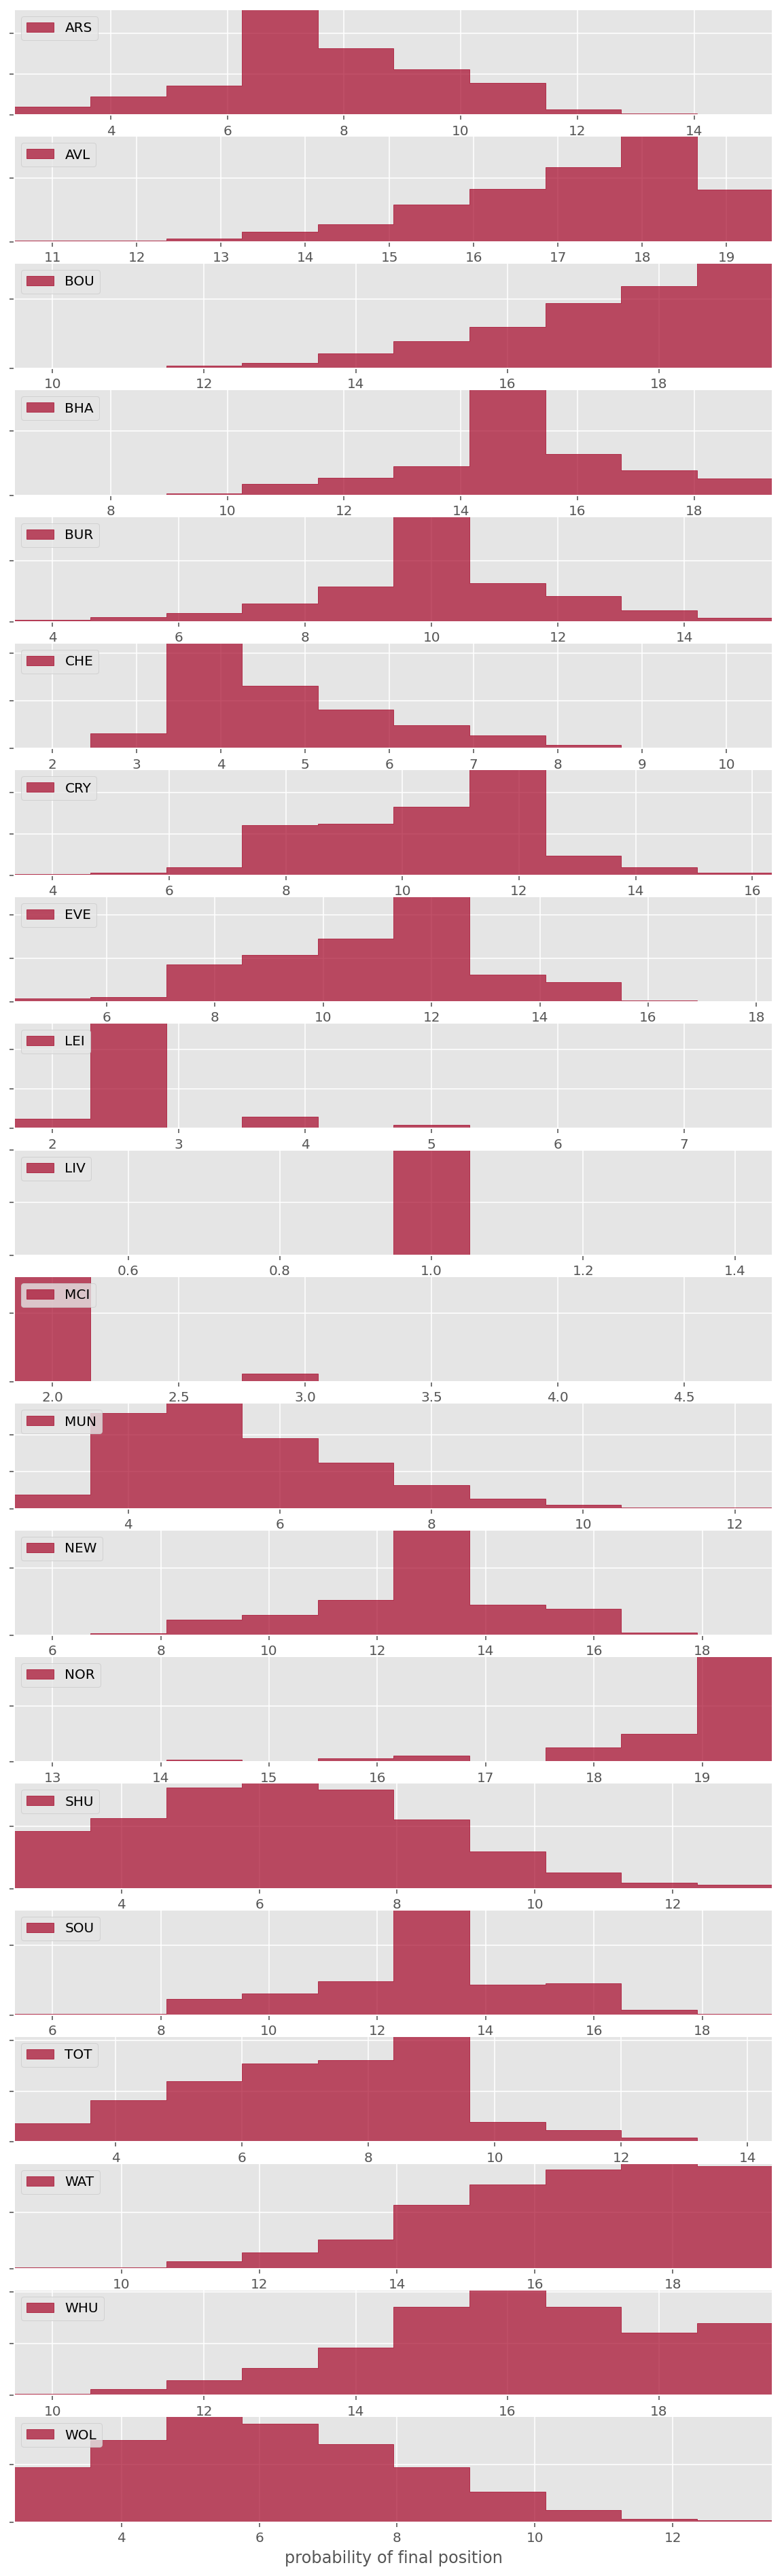

In [16]:
figsize(10, 34)
for k, team in enumerate(list(current_season.teams["team"])):
    sx = plt.subplot(len(current_season.teams), 1, k+1)
    plt.xlabel("probability of final position") \
        if k in [0, len(current_season.teams)-1] else None
    plt.setp(sx.get_yticklabels(), visible=False)
    plt.hist(positions[team], alpha=0.7, align='left', histtype="stepfilled",
         label=team, color="#A60628", density=True, edgecolor="#A60628")
    plt.legend(loc="upper left")
    plt.autoscale(tight=True)


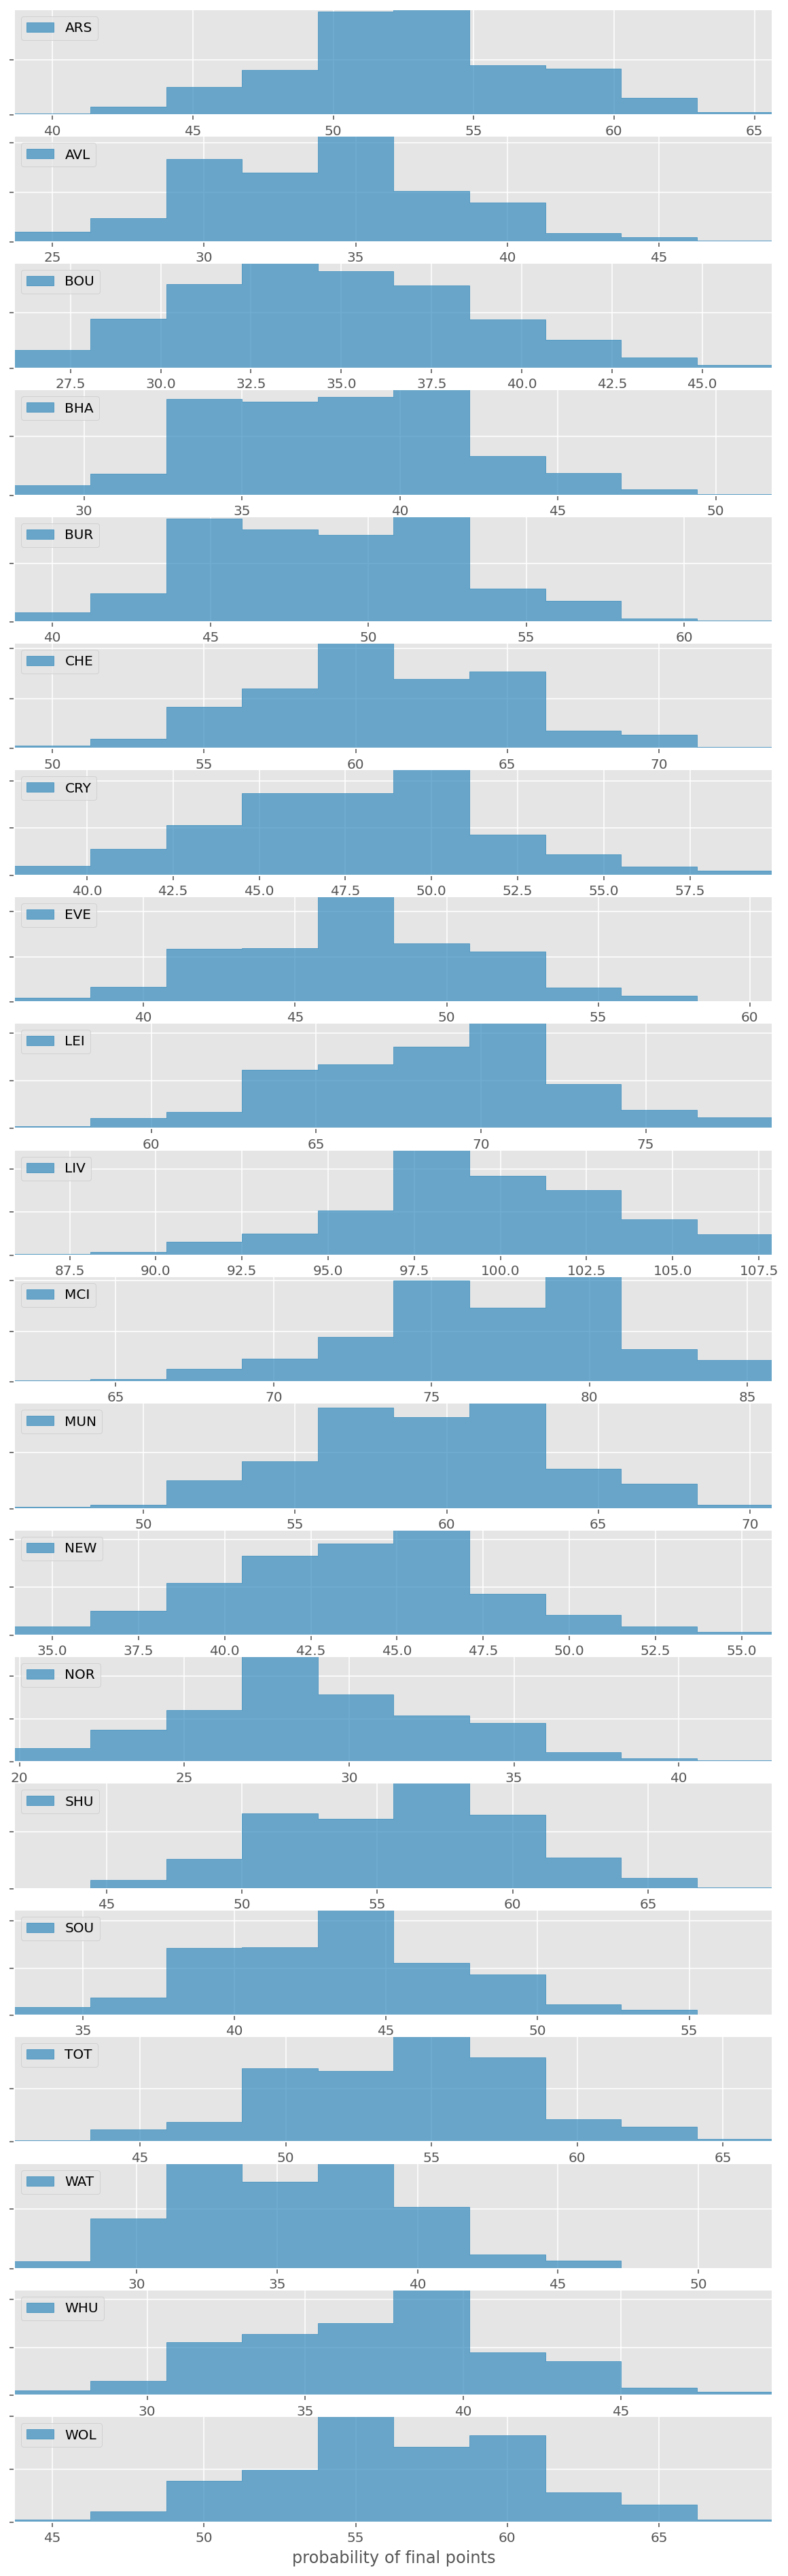

In [17]:
figsize(10, 34)
for k, team in enumerate(list(current_season.teams["team"])):
    sx = plt.subplot(len(current_season.teams), 1, k+1)
    plt.xlabel("probability of final points") \
        if k in [0, len(current_season.teams)-1] else None
    plt.setp(sx.get_yticklabels(), visible=False)
    plt.hist(points[team], alpha=0.7, align='left', histtype="stepfilled",
         label=team, color="#348ABD", density=True, edgecolor="#348ABD")
    plt.legend(loc="upper left")
    plt.autoscale(tight=True)


In [18]:
def proportion_less_than(integer, integer_list):
    return len([i for i in integer_list if i< integer])/len(integer_list)

In [19]:
def proportion_greater_than(integer, integer_list):
    return len([i for i in integer_list if i > integer])/len(integer_list)

No handles with labels found to put in legend.


Text(0.5, 0, 'Team')

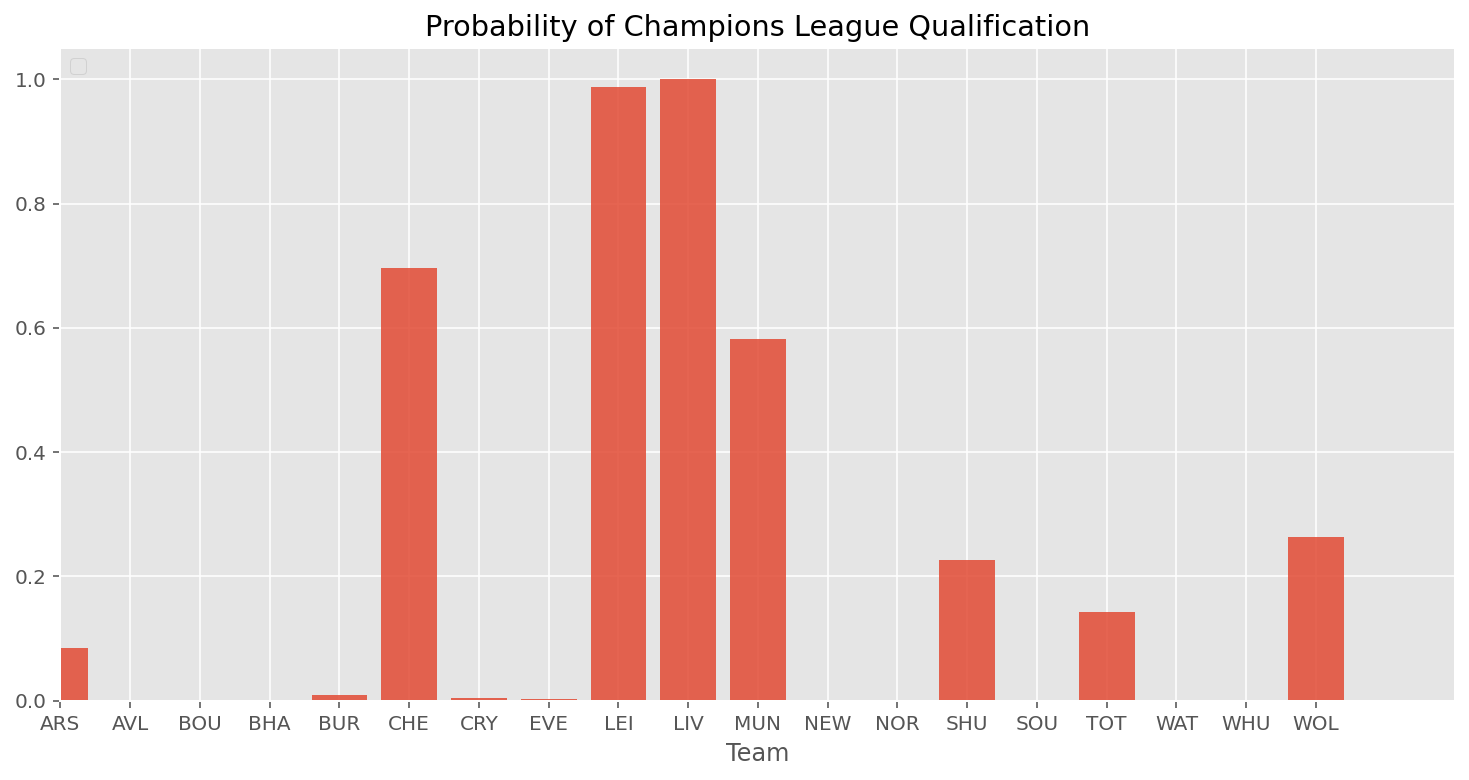

In [20]:

    
figsize(12.5, 6)
teams = list(current_season.teams["team"])
teams.remove("MCI")
plt.bar(teams,[proportion_less_than(6,positions[team]) for team in teams], alpha=0.85)
plt.legend(loc="upper left")
plt.title(r"""Probability of Champions League Qualification""")
plt.xlim([0, 20])
plt.xlabel("Team")


Text(0.5, 0, 'Team')

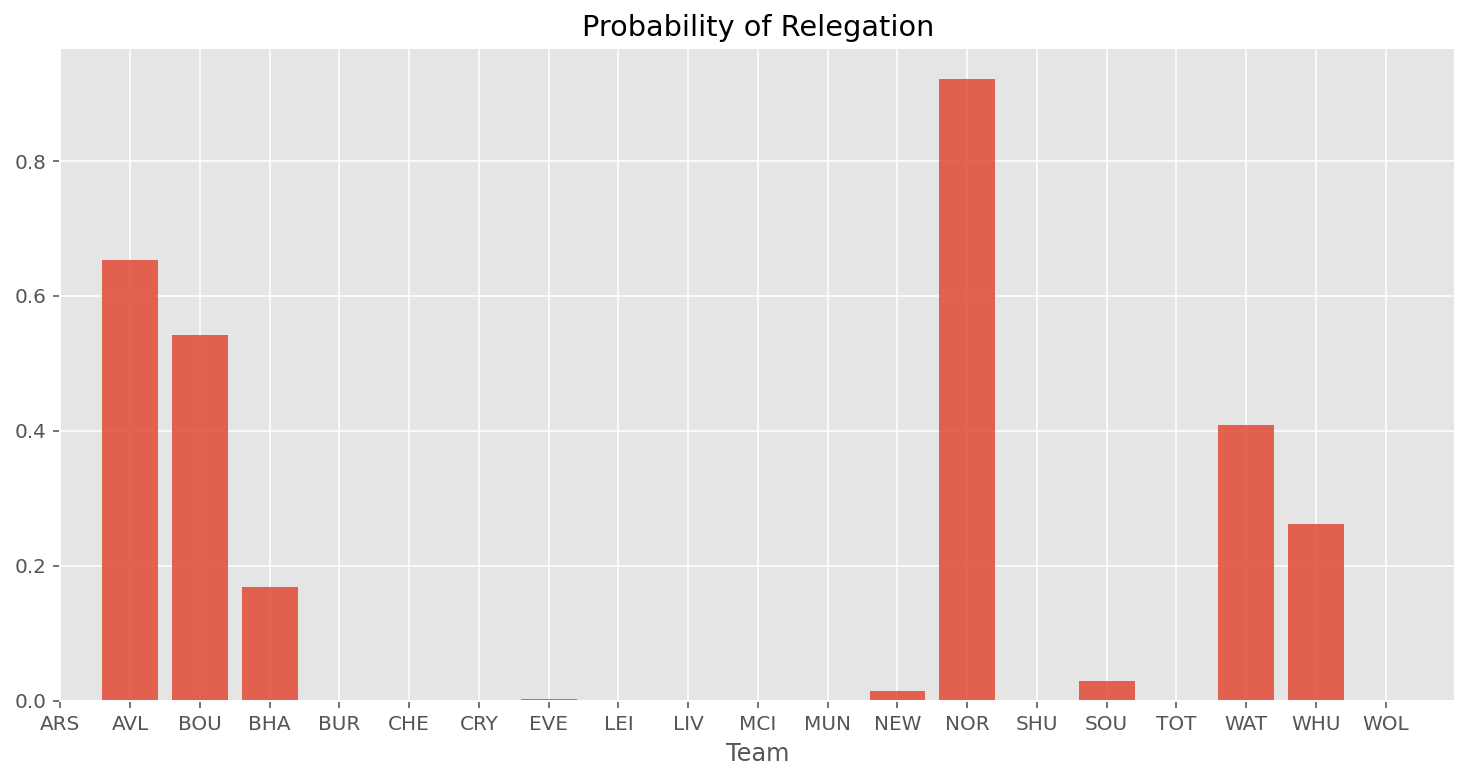

In [21]:

    
figsize(12.5, 6)
teams = list(current_season.teams["team"])
plt.bar(teams,[proportion_greater_than(17,positions[team]) for team in teams], alpha=0.85)
plt.title(r"""Probability of Relegation""")
plt.xlim([0, 20])
plt.xlabel("Team")


I added home advantage values for each team, mostly as a way to take into account that Southampton plays better away than at home. So what would happen if Southampton was able to play against themselves? Would the home team win, or the away team?

In [22]:
home_wins=0
away_wins=0
for i in range(1000):

    home, away =current_season.simulate_game("SOU","SOU")
    if home > away:
        home_wins+=1
    elif home < away:
        away_wins+=1
print(home_wins,away_wins)

if away_wins> home_wins:
    print("Phew looks like the model worked")

342 419
Phew looks like the model worked


What if, like some are proposing, the rest of the season was played on neutral soccer fields without fans? Playing in a neutral venue without fans isn't quite the same as both teams playing in an away game but it is a close approximation. Let's put this into our simulations by removing the home advatage.

In [23]:
class Neutral_Season(Season):
    def simulate_game(self, team1, team2, seed=False):
        """
        Args:
            team1: 3 letter name of team e.g. "ARS"
            team2: 3 letter name of team e.g. "ARS"
            seed: Integer, maximum possible value is len(self.trace)

        Returns:
            list: [int(team1_goals), int(team2_goals)]
        """
        if not seed:
            seed =  np.random.randint(len(self.trace))

        team1_index = self.team_index(team1)
        team2_index = self.team_index(team2)

        team1_attack, team2_attack = self.trace["atts"][seed][[team1_index, team2_index]]
        team1_defence, team2_defence = self.trace["defs"][seed][[team1_index, team2_index]]

        intercept = self.trace["intercept"][seed]

        team1_goals = np.random.poisson(np.exp(intercept + team1_attack + team2_defence))
        team2_goals = np.random.poisson(np.exp(intercept + team2_attack + team1_defence))
        return team1_goals, team2_goals



Run the same simulation as above, 1000 seasons at neutral venues from here on out.

In [24]:
neutral_season = Neutral_Season(season_df, trace)
neutral_positions = dict(zip(list(current_season.teams["team"]), [[] for i in range (20)]))
neutral_points = dict(zip(list(current_season.teams["team"]), [[] for i in range (20)]))

for i in range(1000):
    print(i)
    simulated_season = Season(neutral_season.simulate_remaining_games(), trace)
    simulated_league_table = simulated_season.league_table()
    for i,row in simulated_league_table.iterrows():
        neutral_positions[row["Team"]].append(row["Pos"])
        neutral_points[row["Team"]].append(row["Pts"])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

Text(0.5, 0, 'Team')

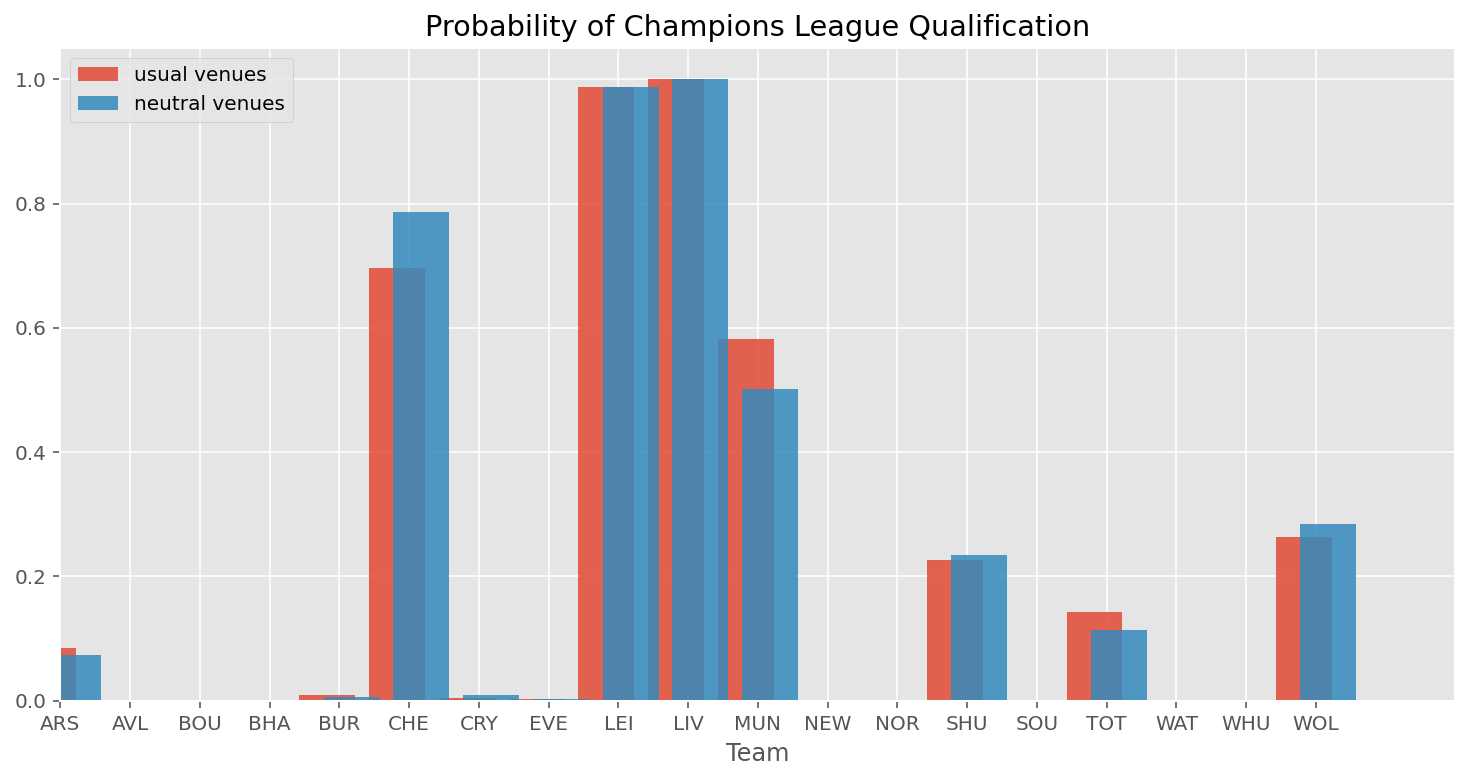

In [25]:

width = 0.35

figsize(12.5, 6)

teams = list(current_season.teams["team"])
teams.remove("MCI")
x = np.arange(len(teams))
plt.bar(x-width/2,[proportion_less_than(6,positions[team]) for team in teams], alpha=0.85, label="usual venues")

plt.bar(x+width/2,[proportion_less_than(6,neutral_positions[team]) for team in teams], alpha=0.85, label="neutral venues")


plt.xticks(x, teams)
plt.legend(loc="upper left");

plt.title(r"""Probability of Champions League Qualification""")
plt.xlim([0, 20])
plt.xlabel("Team")


The only significant change in the race for a champions league spot is between Chelsea and Manchester United with Chelsea gaining about 10% chance of qualifying and MUN losing an equivelant 10% chance of qualifiying.

Lets do a random sampling of the simulated league positons so we can make a confidence interval to see if the change is statistically significant.

In [26]:
che_change_in_position=[]
for i in range(1000):
    average_neutral_sample = np.average(np.random.choice(neutral_positions["CHE"],100))
    average_sample = np.average(np.random.choice(positions["CHE"],100))
    che_change_in_position.append(average_neutral_sample-average_sample)

In [27]:
mun_change_in_position=[]
for i in range(1000):
    average_neutral_sample = np.average(np.random.choice(neutral_positions["MUN"],100))
    average_sample = np.average(np.random.choice(positions["MUN"],100))
    mun_change_in_position.append(average_neutral_sample-average_sample)

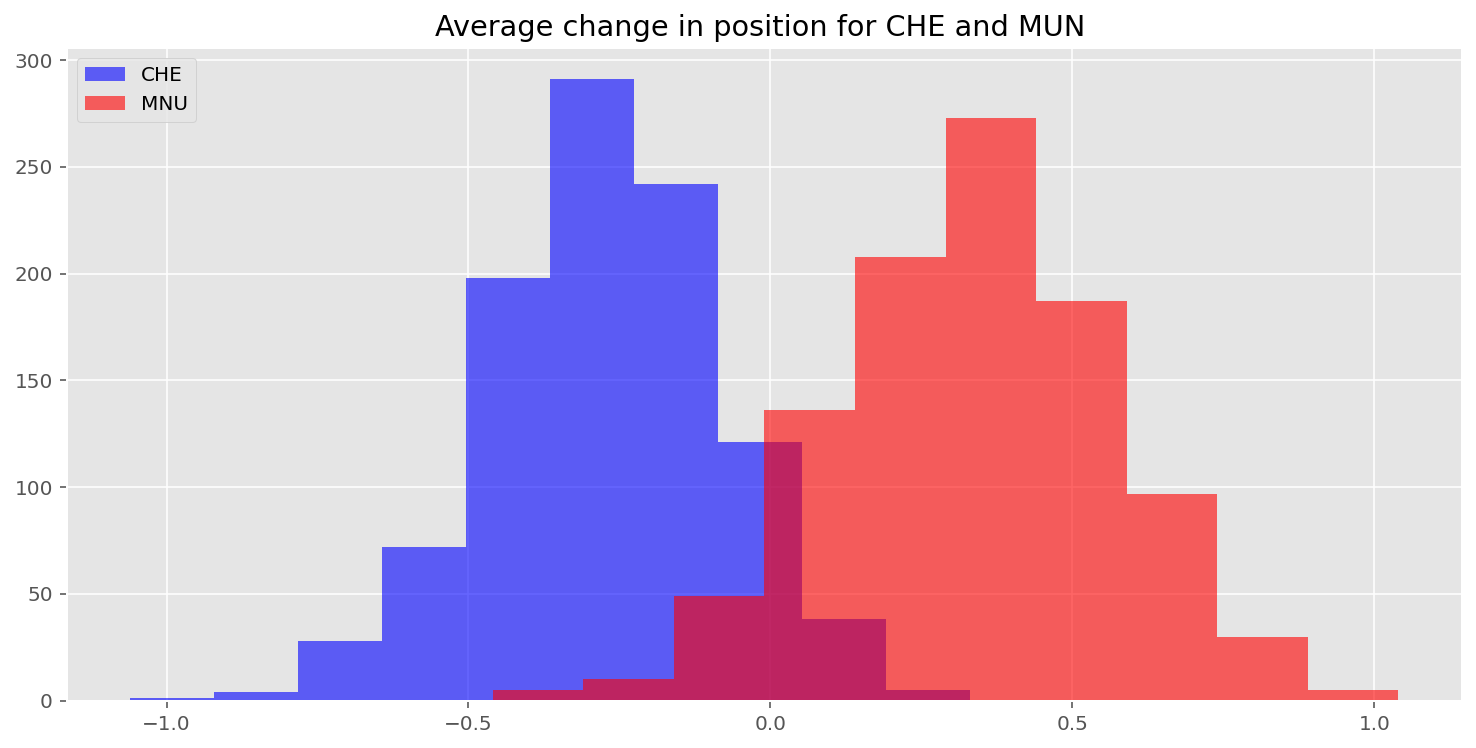

In [28]:
plt.title("Average change in position for CHE and MUN ")
plt.hist(che_change_in_position, color="blue", alpha=0.6, label="CHE")
plt.hist(mun_change_in_position, color="red", alpha=0.6, label="MNU")
plt.legend(loc="upper left")

In [29]:
print("Proportion of times when CHE would benefit:")
len([change for change in che_change_in_position if change<0])/len(che_change_in_position)

Proportion of times when CHE would benefit:


0.91

In [30]:
print("Proportion of times when MUN would benefit:")
len([change for change in mun_change_in_position if change<0])/len(mun_change_in_position)

Proportion of times when MUN would benefit:


0.07

Text(0.5, 0, 'Team')

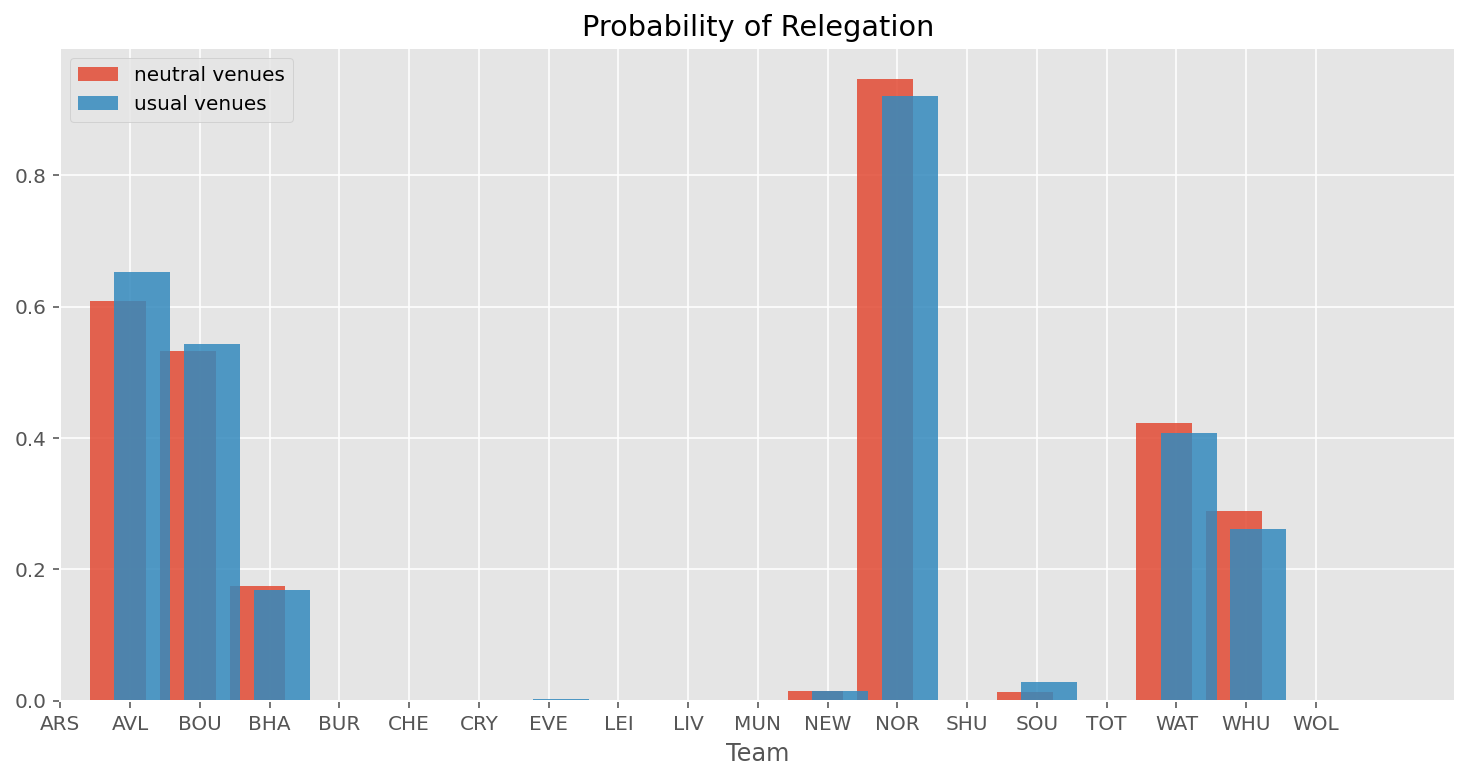

In [31]:

width = 0.35

figsize(12.5, 6)

teams = list(current_season.teams["team"])
teams.remove("MCI")
x = np.arange(len(teams))
plt.bar(x-width/2,[proportion_greater_than(17,neutral_positions[team]) for team in teams], alpha=0.85, label="neutral venues")

plt.bar(x+width/2,[proportion_greater_than(17,positions[team]) for team in teams], alpha=0.85, label="usual venues")

plt.xticks(x, teams)
plt.legend(loc="upper left");

plt.title(r"""Probability of Relegation""")
plt.xlim([0, 20])
plt.xlabel("Team")


There's no real change in race to the bottom, Norwich are on the way out and the chances of Astron Villa, Bournemouth, Watford, West Ham and Brighton aren't changed by playing in a bubble.